In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries to verify installation
import seaborn as sns
!pip install imbalanced-learn
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from datetime import datetime
from matplotlib.colors import Normalize
import tqdm
import PIL
import pickle
import sys
import json
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from scipy.spatial.distance import euclidean
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM

import warnings

warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
path = "drive/MyDrive/"

In [ ]:
df = pd.read_csv(f'{path}data.csv')

Data

In [ ]:
print(df.shape)
df.head()

(5000000, 20)


,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,y,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0,0.0


In [ ]:
df = df.drop('timestamp', axis = 1)

In [ ]:
# split the data into x and y dataframes

X_df = df.drop('y', axis=1)
X_df = X_df.drop('category', axis=1)
y_df = df['y']

In [ ]:
print(X_df.shape)
X_df.head()


(5000000, 17)


,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1
0,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229
2,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833
3,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688
4,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669


In [ ]:
print(y_df.shape)
y_df.head()

(5000000,)


,y
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
# check for missing values

df.isnull().sum()

,0
aimp,0
amud,0
arnd,0
asin1,0
asin2,0
adbr,0
adfl,0
bed1,0
bed2,0
bfo1,0


In [ ]:
# load metadata csv

df_metadata = pd.read_csv(f'{path}metadata.csv')

In [ ]:
print(df_metadata.shape)
df_metadata.head()

(200, 5)


,start_time,end_time,root_cause,affected,category
0,2023-01-12 15:11:45,2023-01-12 15:20:05,bso3,['cfo1'],12
1,2023-01-12 16:27:46,2023-01-12 17:51:06,bso3,['cfo1'],1
2,2023-01-12 18:19:35,2023-01-12 18:36:15,bfo2,['cso1'],8
3,2023-01-12 20:46:32,2023-01-12 20:51:32,bed2,['ced1'],7
4,2023-01-13 05:57:10,2023-01-13 06:02:10,bfo1,['cfo1'],9


In [ ]:
df_metadata.category.value_counts()

,count
category,
8,28
3,22
12,20
7,20
9,18
4,15
5,13
2,13
6,12


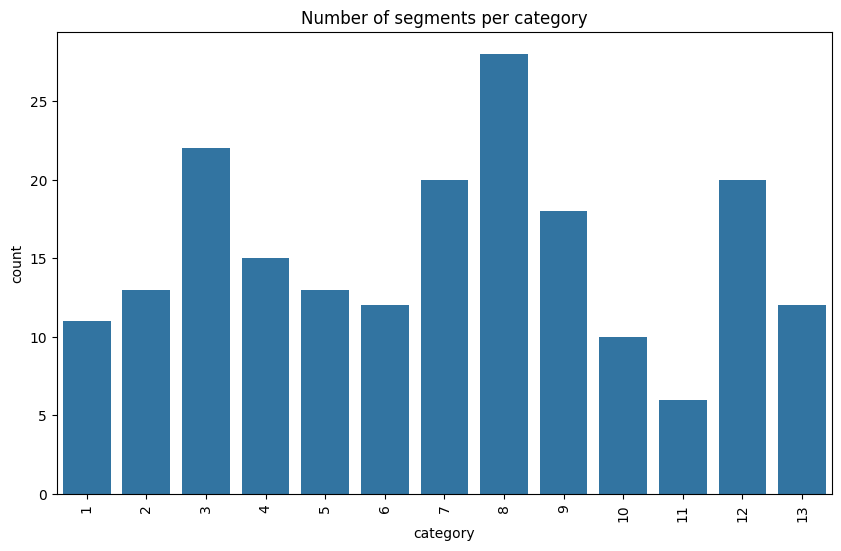

In [ ]:
# Plot graph of categories

plt.figure(figsize=(10,6))

sns.countplot(x='category', data=df_metadata)

plt.title('Number of segments per category')

plt.xticks(rotation=90)

plt.show()

In [ ]:
# check for class imbalance

y_df.value_counts()

,count
y,
0.0,4809900
1.0,190100


In [ ]:
# check for labels in first 1000000 rows

y_df[:1000000].value_counts()

,count
y,
0.0,1000000


In [ ]:
y_df[1000000:].value_counts()

,count
y,
0.0,3809900
1.0,190100


In [ ]:
# Check for values in the category column from the original dataframe
print(df['category'].value_counts())

# Or, from df_metadata if you're analyzing metadata categories
print(df_metadata['category'].value_counts())


category
0.0     4809900
8.0       32600
1.0       20400
12.0      19600
7.0       19100
3.0       18000
4.0       15600
6.0       12100
2.0       12000
9.0       10400
5.0        9900
11.0       9100
10.0       6400
13.0       4900
Name: count, dtype: int64
category
8     28
3     22
12    20
7     20
9     18
4     15
5     13
2     13
6     12
13    12
1     11
10    10
11     6
Name: count, dtype: int64


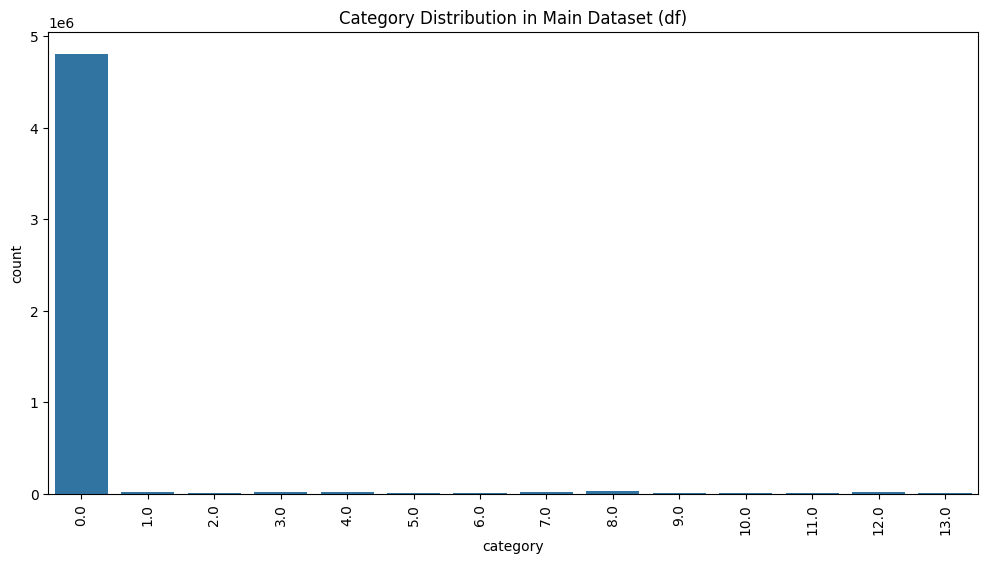

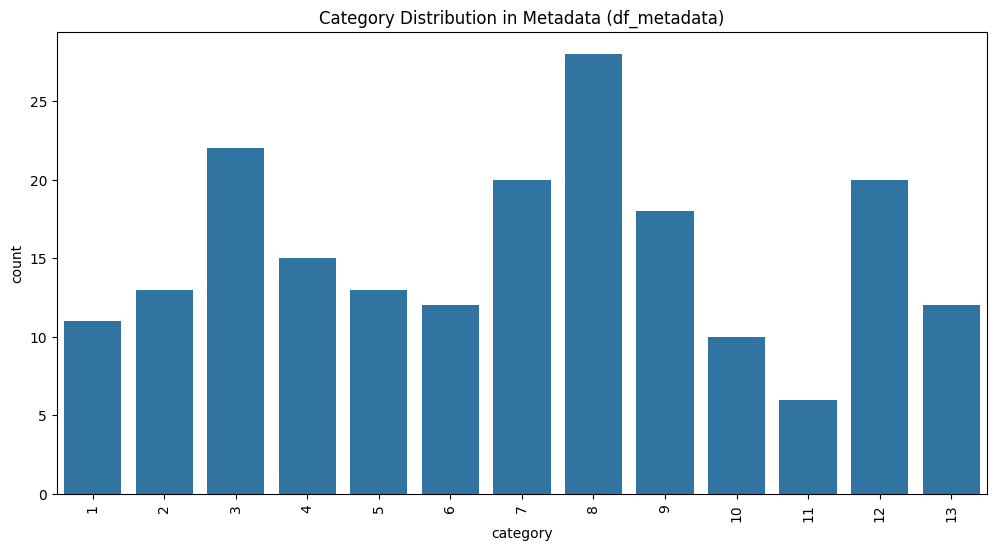

In [ ]:
# Plot category counts from the main dataset
plt.figure(figsize=(12, 6))
sns.countplot(x=df['category'])
plt.title("Category Distribution in Main Dataset (df)")
plt.xticks(rotation=90)
plt.show()

# Plot category counts from metadata
plt.figure(figsize=(12, 6))
sns.countplot(x=df_metadata['category'])
plt.title("Category Distribution in Metadata (df_metadata)")
plt.xticks(rotation=90)
plt.show()


In [ ]:
# split the data into x and y dataframes, keeping 'category' in X_df
X_df = df.drop('y', axis=1)
y_df = df['y']


In [ ]:
X_df['category'].value_counts()

,count
category,
0.0,4809900
8.0,32600
1.0,20400
12.0,19600
7.0,19100
3.0,18000
4.0,15600
6.0,12100
2.0,12000


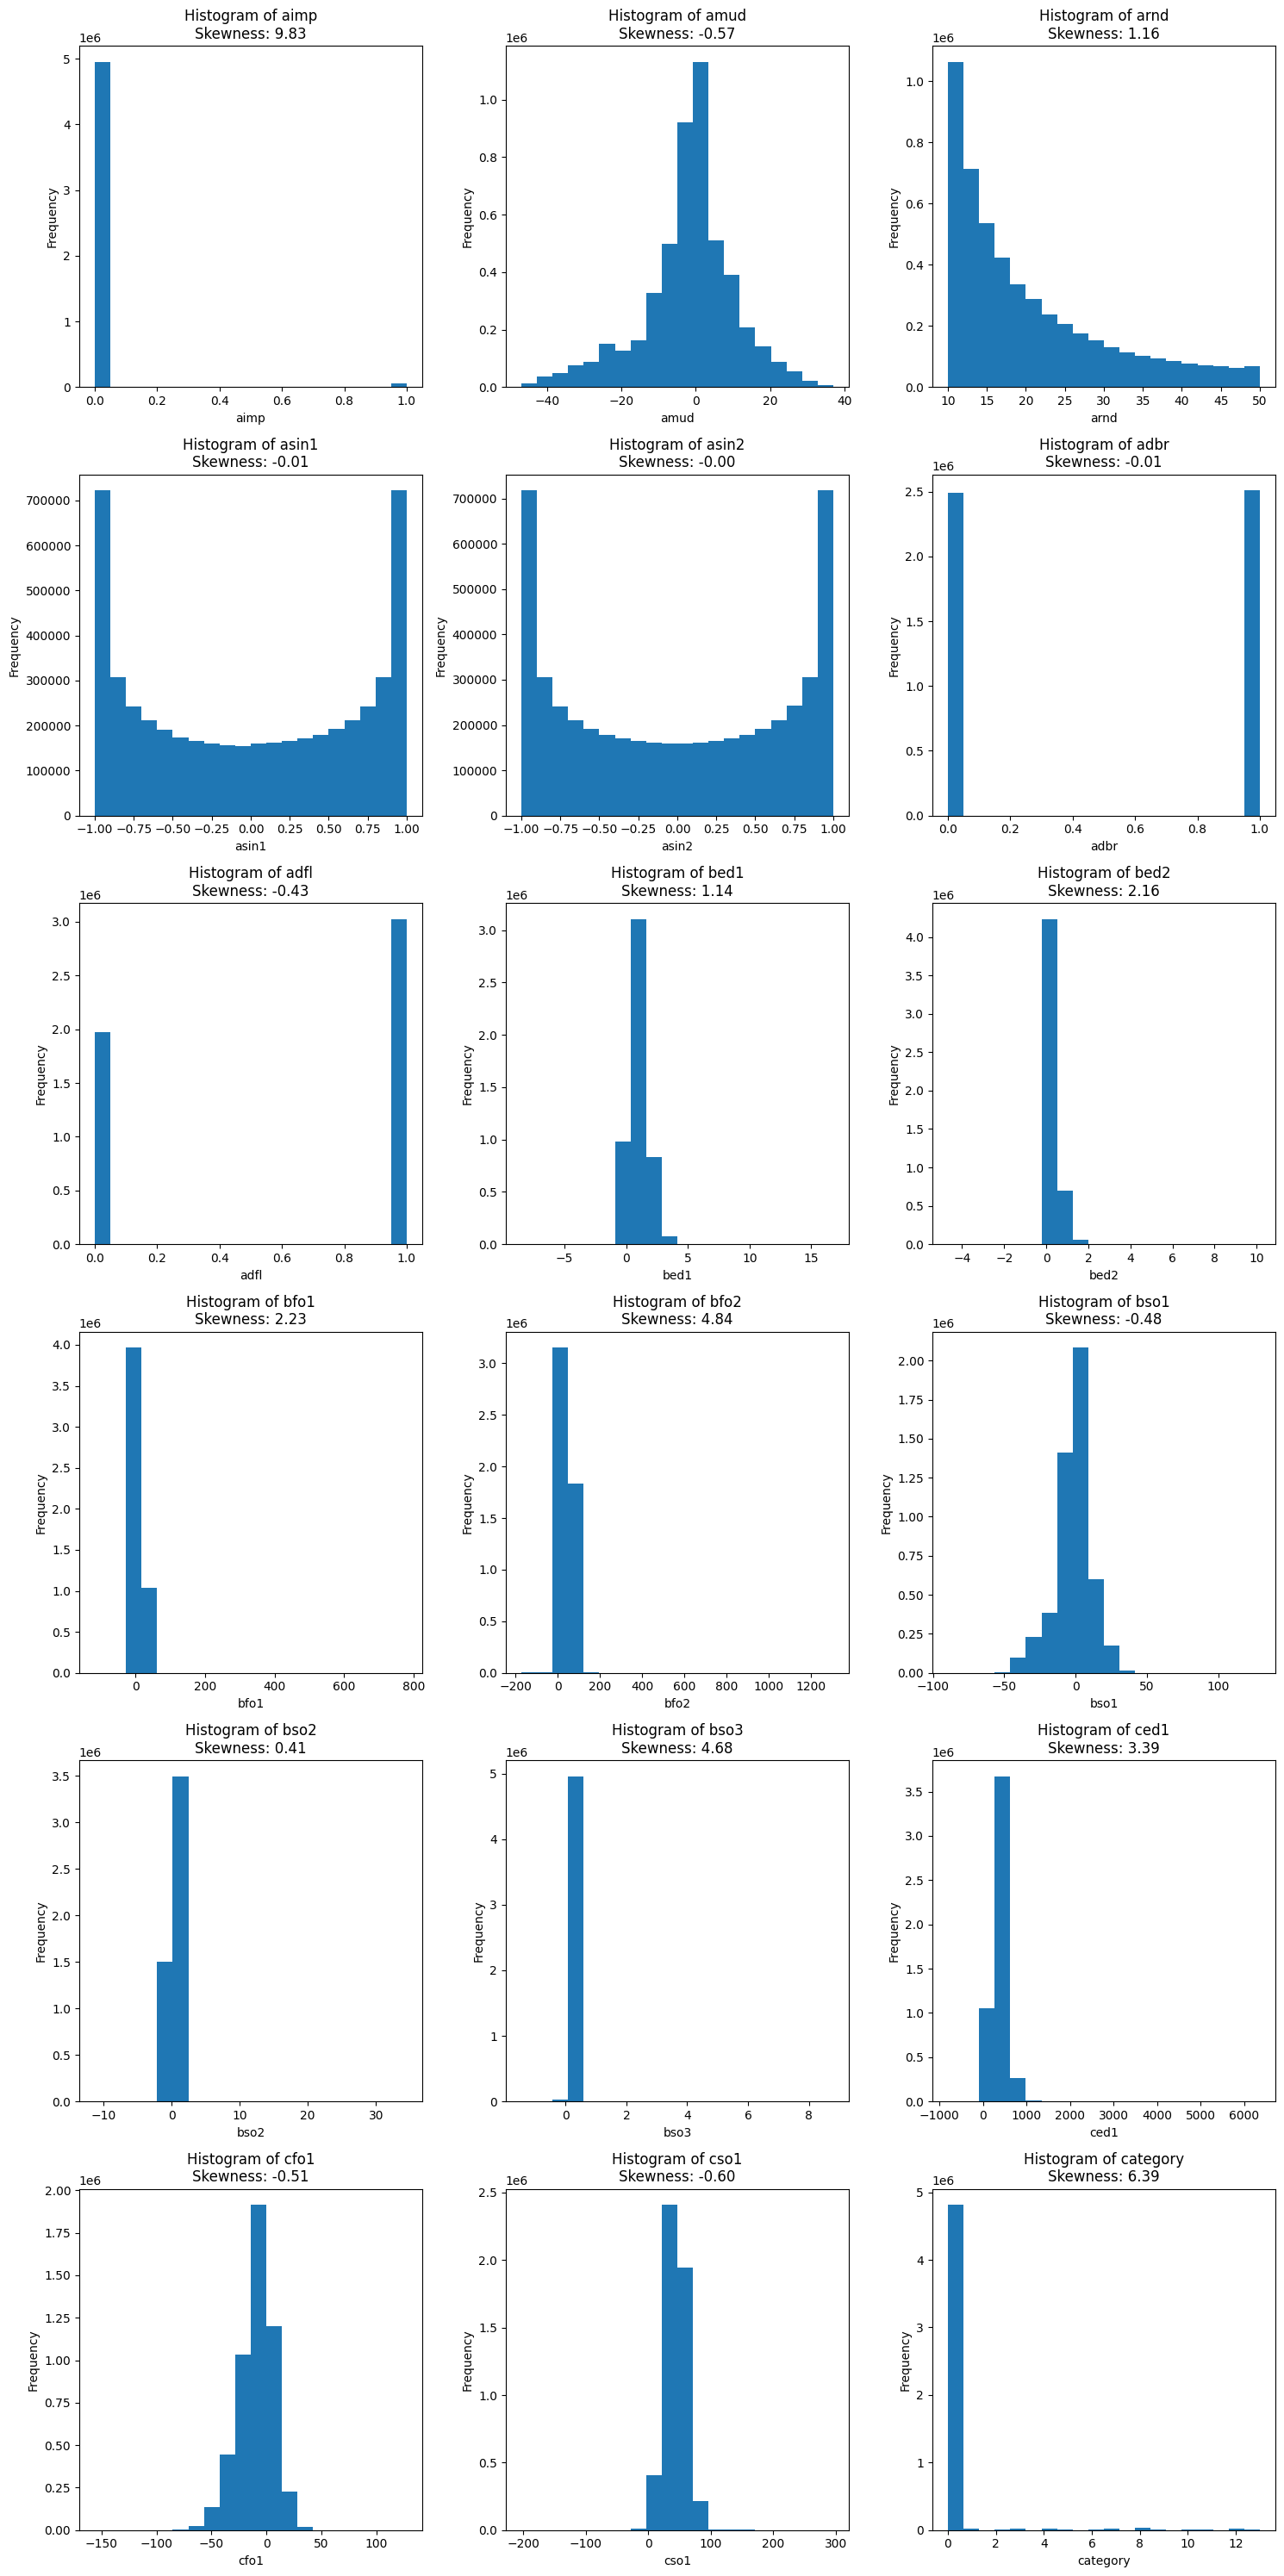

In [ ]:
# Plot histograms for each numeric feature
numeric_features = X_df.select_dtypes(include=['float64', 'int64'])  # Select numeric features
numeric_columns = numeric_features.columns

num_plots = len(numeric_columns)
num_rows = int(np.ceil(num_plots/3)) # Adjust the number of rows as needed

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(numeric_columns):
    row = i // 3
    col = i % 3
    axes[row, col].hist(X_df[column], bins=20)  # Adjust the number of bins as needed
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Histogram of {column}\nSkewness: {skew(df[column]):.2f}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots % 3, 3):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()

In [ ]:
# check the features for which number of unique values is small

discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]

for feature in discrete_features:
    print(f'{feature}: {X_df[feature].unique()}')

aimp: [0. 1.]
amud: [  1.  -1.   2.   3.   6.   5.   0.  10.   7.   4.  -4.   9.  11.   8.
  16.  12.  -3.  -6.  -5. -12. -13.  -7.  -9.  -2. -10. -11.  -8. -15.
 -14. -17. -19. -21. -24. -23. -22. -25. -28. -16. -20. -30. -29. -26.
 -27. -32. -31. -34. -37. -35. -18.  13.  15.  14.  18.  21.  22.  25.
  26.  30.  27.  24.  23.  29.  28.  20.  19.  17. -33. -41. -38. -39.
 -44. -45. -36. -40. -43. -46. -42. -47.  31.  32.  33.  34.  37.  36.
  35.]
adbr: [0. 1.]
adfl: [0. 1.]
category: [ 0. 12.  1.  8.  7.  9.  4.  3.  5. 11. 10.  2. 13.  6.]


In [ ]:
# Define the number of splits
n_splits = 3

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform the splits
fold = 0
for train_index, test_index in tscv.split(X_df):
    fold += 1
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    print(f"Fold {fold}")
    print(f"TRAIN indices: {train_index}")
    print(f"TEST indices: {test_index}")

Fold 1
TRAIN indices: [      0       1       2 ... 1249997 1249998 1249999]
TEST indices: [1250000 1250001 1250002 ... 2499997 2499998 2499999]
Fold 2
TRAIN indices: [      0       1       2 ... 2499997 2499998 2499999]
TEST indices: [2500000 2500001 2500002 ... 3749997 3749998 3749999]
Fold 3
TRAIN indices: [      0       1       2 ... 3749997 3749998 3749999]
TEST indices: [3750000 3750001 3750002 ... 4999997 4999998 4999999]


In [ ]:
# get contamination rates of train and test sets of all folds

contamination_rates = {}

for train_index, test_index in tscv.split(X_df):
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
    train_contamination_rate = np.mean(y_train)
    test_contamination_rate = np.mean(y_test)
    contamination_rates[f"Fold {len(contamination_rates)+1}"] = {
        "Train": train_contamination_rate,
        "Test": test_contamination_rate
    }

contamination_rates

{'Fold 1': {'Train': 0.0152, 'Test': 0.04632},
 'Fold 2': {'Train': 0.03076, 'Test': 0.04344},
 'Fold 3': {'Train': 0.034986666666666666, 'Test': 0.04712}}

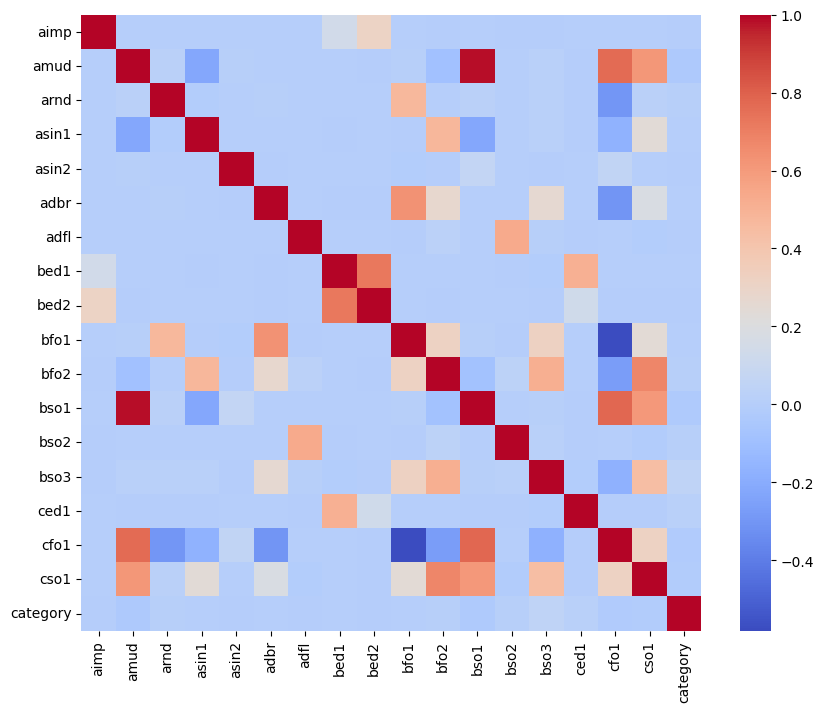

In [ ]:
# check for correlation matrix between columns, using sns heatmap

corr = X_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', linecolor='black')
plt.show()

In [ ]:
def preprocess_data(X_train, X_test, y_train=None, y_test=None, correlation_threshold=0.9):
    """
    Preprocess the data by scaling features, handling missing values, and dropping highly correlated features.

    Parameters:
    X_train (DataFrame): Training feature set.
    X_test (DataFrame): Test feature set.
    y_train (Series, optional): Training labels.
    y_test (Series, optional): Test labels.
    correlation_threshold (float): Threshold for dropping highly correlated features.

    Returns:
    X_train_scaled, X_test_scaled: Scaled and preprocessed training and test feature sets.
    """

    # Drop highly correlated features in the training set, display highly correlated features
    corr_matrix_train = X_train.corr().abs()
    upper = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print(f"Highly correlated features to drop for train set: {to_drop}")
    X_train_reduced = X_train.drop(columns=to_drop)

    corr_matrix_test = X_test.corr().abs()
    upper = corr_matrix_test.where(np.triu(np.ones(corr_matrix_test.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print(f"Highly correlated features to drop for test set: {to_drop}")
    X_test_reduced = X_test.drop(columns=to_drop)

    numeric_features = X_train_reduced.select_dtypes(include=['float64', 'int64'])  # Select numeric features
    numeric_columns = numeric_features.columns
    discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]
    continuous_features = [feature for feature in numeric_columns if feature not in discrete_features]

    scaler = StandardScaler()
    X_train_scaled = X_train_reduced.copy()
    X_train_scaled[continuous_features] = scaler.fit_transform(X_train_reduced[continuous_features])
    X_test_scaled = X_test_reduced.copy()
    X_test_scaled[continuous_features] = scaler.transform(X_test_reduced[continuous_features])

    return X_train_scaled, X_test_scaled

In [ ]:
def augment_data(X_train, y_train):
    """
    Augment the training data using SMOTE.

    Parameters:
    X_train (array-like): Training feature set.
    y_train (array-like): Training labels.

    Returns:
    X_train_resampled, y_train_resampled: Augmented training feature set and labels.
    """
    if len(np.unique(y_train)) > 1:  # Check if there is more than one class
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        return X_train_resampled, y_train_resampled
    else:
        # If there's only one class, return the original data
        print("SMOTE not applied, only one class present.")
        return X_train, y_train

In [ ]:
# Preprocess and augment the data for each fold
X_train_scaled, X_test_scaled = {}, {}
y_train_scaled, y_test_scaled = {}, {}
X_train_augmented, y_train_augmented = {}, {}

for fold, (train_index, test_index) in enumerate(tscv.split(X_df)):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Preprocess the data
    X_train_scaled[fold], X_test_scaled[fold] = preprocess_data(X_train, X_test, y_train, y_test)
    y_train_scaled[fold], y_test_scaled[fold] = y_train, y_test

    print(f"Fold {fold} preprocessing complete")
    print(X_train_scaled[fold].shape)
    print(X_test_scaled[fold].shape)

    # Augment the training data
    X_train_augmented[fold], y_train_augmented[fold] = augment_data(X_train_scaled[fold], y_train_scaled[fold])

    # Print shapes of the augmented training data
    print(f"Fold {fold} augmentation complete")
    print(f"Augmented Train Data Shape: {X_train_augmented[fold].shape}")
    print(f"Augmented Train Labels Shape: {y_train_augmented[fold].shape}")
    print("\n")

Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 0 preprocessing complete
(1250000, 17)
(1250000, 17)
Fold 0 augmentation complete
Augmented Train Data Shape: (2462000, 17)
Augmented Train Labels Shape: (2462000,)


Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 1 preprocessing complete
(2500000, 17)
(1250000, 17)
Fold 1 augmentation complete
Augmented Train Data Shape: (4846200, 17)
Augmented Train Labels Shape: (4846200,)


Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 2 preprocessing complete
(3750000, 17)
(1250000, 17)
Fold 2 augmentation complete
Augmented Train Data Shape: (7237600, 17)
Augmented Train Labels Shape: (7237600,)




In [ ]:
X_train = X_train_augmented
y_train = y_train_augmented

X_test = X_test_scaled
y_test = y_test_scaled

Models

LSTM

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

def train_lstm(X_train, y_train, n_units=64, n_epochs=10, batch_size=32, random_state=42):
    """
    Train a Long Short-Term Memory (LSTM) model.

    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training labels.
    n_units (int): Number of units in the LSTM layer. Default is 64.
    n_epochs (int): Number of epochs for training. Default is 10.
    batch_size (int): Number of samples per gradient update. Default is 32.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    Sequential: The trained LSTM model.
    """

    # Reshape the input data
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

    # Create validation set from the last 10% of the training data
    n_train = int(X_train_reshaped.shape[0] * 0.9)
    X_train_split, X_val = X_train_reshaped[:n_train], X_train_reshaped[n_train:]
    y_train_split, y_val = y_train[:n_train], y_train[n_train:]

    # Create an LSTM model
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    # Display model summary
    model.summary()

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )

    # Fit the model
    history = model.fit(X_train_split, y_train_split, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

    return history, model


In [ ]:
# Train an LSTM model for each fold

lstm_models = {}
lstm_histories = {}

for fold in range(n_splits):
    lstm_histories[fold], lstm_models[fold] = train_lstm(X_train[fold], y_train[fold])
    print(f"Fold {fold} LSTM model trained")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
69244/69244 [==============================] - 170s 2ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 3.2874e-09 - val_accuracy: 1.0000
Epoch 2/10
69244/69244 [==============================] - 168s 2ms/step - loss: 1.5611e-09 - accuracy: 1.0000 - val_loss: 3.2438e-09 - val_accuracy: 1.0000
Epoch 3/10
69244/69244 [==============================] - 176s 3ms/step - loss: 1.5111e-09 - accuracy: 1.000

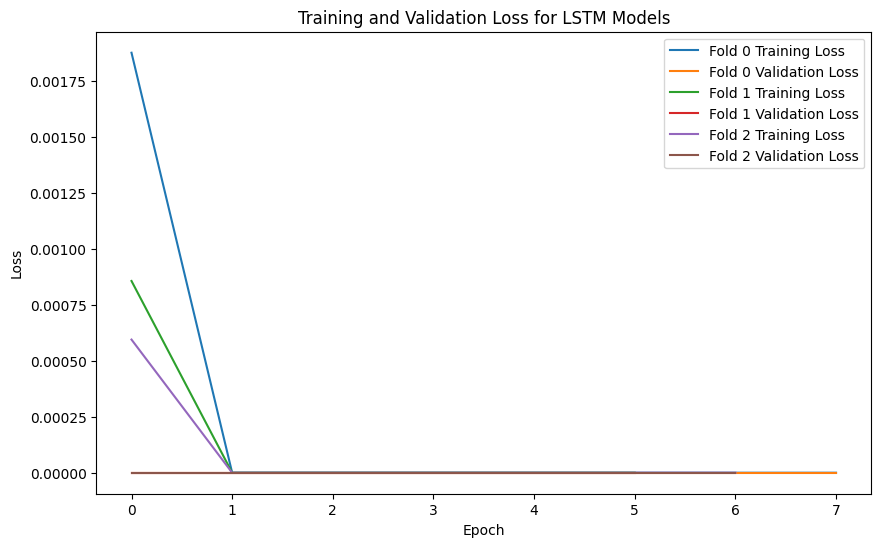

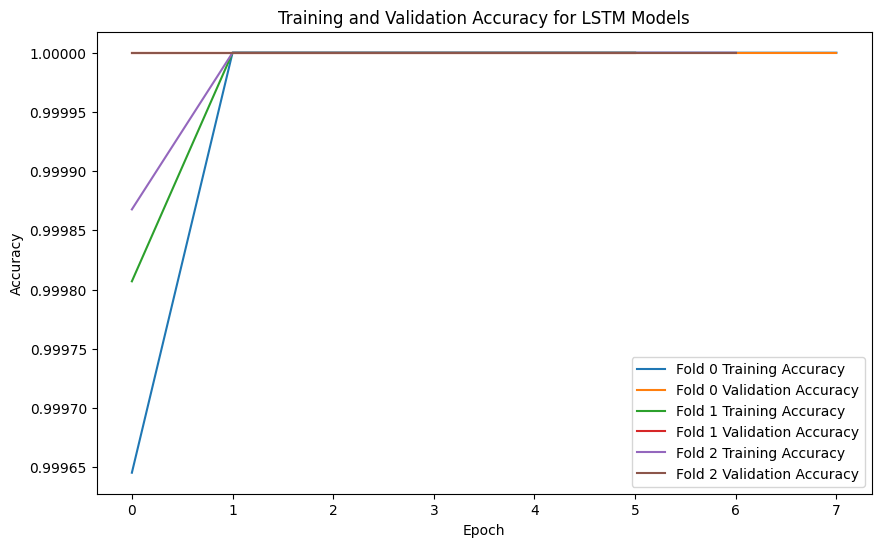

In [ ]:
# plot training and validation loss

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = lstm_histories[fold]
    plt.plot(history.history['loss'], label=f"Fold {fold} Training Loss")
    plt.plot(history.history['val_loss'], label=f"Fold {fold} Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for LSTM Models')
plt.legend()
plt.show()

# plot training and validation accuracy

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = lstm_histories[fold]
    plt.plot(history.history['accuracy'], label=f"Fold {fold} Training Accuracy")
    plt.plot(history.history['val_accuracy'], label=f"Fold {fold} Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for LSTM Models')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_NN(model, X_test, y_test):
    """
    Evaluate a neural network model on test data.

    Parameters:
    model (Sequential): The trained model to evaluate.
    X_test (array): Test feature set.
    y_test (array): True labels for the test set.

    Returns:
    dict: Dictionary containing accuracy, precision, recall, and F1 score.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype("int32")  # Assuming binary classification with sigmoid output

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1}


In [ ]:
# Evaluate the models for each fold
lstm_metrics = {}

for fold in range(n_splits):
    # Reshape X_test to match the input shape expected by the LSTM model
    X_test_reshaped = X_test[fold].values.reshape(X_test[fold].shape[0], 1, X_test[fold].shape[1])

    # Evaluate the model on the reshaped test set
    lstm_metrics[fold] = evaluate_NN(lstm_models[fold], X_test_reshaped, y_test[fold])
    print(f"Fold {fold} LSTM model evaluated")

# Display the evaluation metrics for each fold
lstm_metrics_df = pd.DataFrame(lstm_metrics).T
lstm_metrics_df


39063/39063 [==============================] - 56s 1ms/step
Fold 0 LSTM model evaluated
39063/39063 [==============================] - 57s 1ms/step
Fold 1 LSTM model evaluated
39063/39063 [==============================] - 57s 1ms/step
Fold 2 LSTM model evaluated


,accuracy,precision,recall,f1_score
0,1.000000,1.0,1.000000,1.00000
1,0.996017,1.0,0.908306,0.95195
2,1.000000,1.0,1.000000,1.00000


39063/39063 [==============================] - 56s 1ms/step


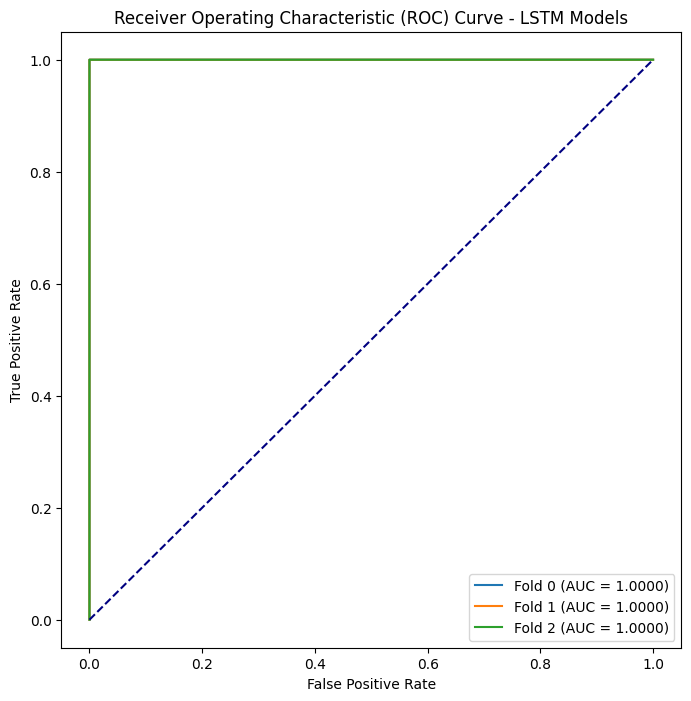

In [ ]:
# roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape(X_test[fold].shape[0], 1, X_test[fold].shape[1])
    y_prob = lstm_models[fold].predict(X_test_reshaped)
    fpr, tpr, _ = roc_curve(y_test[fold], y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LSTM Models')
plt.legend()
plt.show()

In [ ]:
# plot confusion matrix

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape(X_test[fold].shape[0], 1, X_test[fold].shape[1])
    y_prob = lstm_models[fold].predict(X_test_reshaped)
    y_pred = (y_prob > 0.5).astype(int)

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred))

39063/39063 [==============================] - 58s 1ms/step
Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1192100                  0
Actual Anomaly                 0              57900
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1192100
         1.0       1.00      1.00      1.00     57900

    accuracy                           1.00   1250000
   macro avg       1.00      1.00      1.00   1250000
weighted avg       1.00      1.00      1.00   1250000

39063/39063 [==============================] - 55s 1ms/step
Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1195700                  0
Actual Anomaly              4979              49321
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1195700
         1.0       1.00      0.91      0.95     54300

    accuracy               

Autoencoder

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import tensorflow as tf
import keras

def train_autoencoder(X_train, n_epochs=10, batch_size=64, random_state=42):
    """
    Train an Autoencoder model for anomaly detection.

    Parameters:
    X_train (DataFrame): Training feature set.
    n_epochs (int): Number of epochs for training. Default is 10.
    batch_size (int): Number of samples per gradient update. Default is 256.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    history (History): The training history of the model.
    autoencoder (Model): The trained Autoencoder model.
    """

    # Reshape data for LSTM input (assuming time series data)
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)  # Add extra dimension for timestep

    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

    # Build LSTM autoencoder model
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.LSTM(16, return_sequences=False),
        keras.layers.RepeatVector(input_shape[0]),  # Repeat the vector to match input shape
        keras.layers.LSTM(16, return_sequences=True),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(input_shape[1]))  # Time distributed dense layer
    ])

    # Display model summary
    model.summary()

    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )

    # Split data into training and validation sets
    n_train = int(X_train_reshaped.shape[0] * 0.9)
    X_train_split, X_val = X_train_reshaped[:n_train], X_train_reshaped[n_train:]

    # Fit the model
    history = model.fit(X_train_split, X_train_split, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, X_val), shuffle=False, verbose=1, callbacks=[early_stopping])

    return history, model


In [ ]:
# Train an Autoencoder model for each fold

autoencoder_models = {}
autoencoder_histories = {}

for fold in range(n_splits):
    autoencoder_histories[fold], autoencoder_models[fold] = train_autoencoder(X_train[fold])
    print(f"Fold {fold} Autoencoder model trained")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 17, 32)            4352      
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVecto  (None, 17, 16)            0         
 r)                                                              
                                                                 
 lstm_5 (LSTM)               (None, 17, 16)            2112      
                                                                 
 lstm_6 (LSTM)               (None, 17, 32)            6272      
                                                                 
 time_distributed (TimeDist  (None, 17, 1)             33        
 ributed)                                             

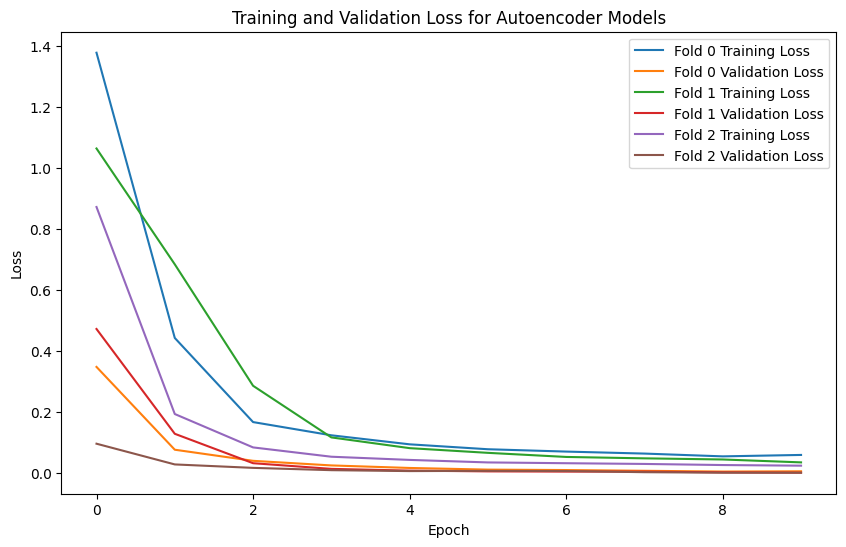

In [ ]:
# plot training and validation loss

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = autoencoder_histories[fold]
    plt.plot(history.history['loss'], label=f"Fold {fold} Training Loss")
    plt.plot(history.history['val_loss'], label=f"Fold {fold} Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Autoencoder Models')
plt.legend()
plt.show()

In [ ]:
def evaluate_autoencoder(model, X_test, y_test, threshold=None):
    """
    Evaluate the LSTM autoencoder model.

    Parameters:
    model (Model): The trained LSTM autoencoder model.
    X_test (ndarray): Test feature set.
    y_test (array-like): True labels for the test set.
    threshold (float): Reconstruction error threshold for classifying anomalies.

    Returns:
    dict: A dictionary containing evaluation metrics.
    """

    # Reshape data for LSTM autoencoder input
    X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Get the reconstruction errors
    X_test_pred = model.predict(X_test)
    reconstruction_errors = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Determine the threshold if not provided
    if threshold is None:
        threshold = np.percentile(reconstruction_errors, 95)  # Adjust the percentile as needed

    # Classify as anomaly or not
    y_pred = (reconstruction_errors > threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, reconstruction_errors)
    accuracy = accuracy_score(y_test, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc_score': roc_auc,
    }

    return metrics

In [ ]:
# evaluate the models for each fold

autoencoder_metrics = {}

for fold in range(n_splits):
    autoencoder_metrics[fold] = evaluate_autoencoder(autoencoder_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} Autoencoder model evaluated")

# Display the evaluation metrics for each fold

autoencoder_metrics_df = pd.DataFrame(autoencoder_metrics).T

autoencoder_metrics_df

39063/39063 [==============================] - 251s 6ms/step
Fold 0 Autoencoder model evaluated
39063/39063 [==============================] - 257s 7ms/step
Fold 1 Autoencoder model evaluated
39063/39063 [==============================] - 252s 6ms/step
Fold 2 Autoencoder model evaluated


,accuracy,precision,recall,f1_score,roc_auc_score
0,0.936962,0.332816,0.359257,0.345532,0.711241
1,0.911418,0.048576,0.055912,0.051986,0.449395
2,0.912938,0.100576,0.106723,0.103558,0.429834


In [ ]:
# take average of evaluation metrics

autoencoder_metrics_avg = autoencoder_metrics_df.mean()

autoencoder_metrics_avg

,0
accuracy,0.920439
precision,0.160656
recall,0.173964
f1_score,0.167025
roc_auc_score,0.530156


39063/39063 [==============================] - 256s 7ms/step


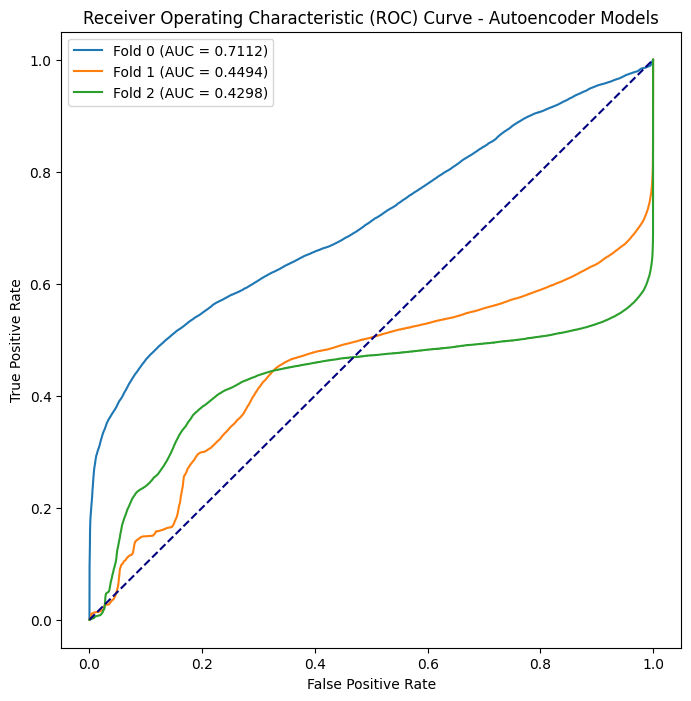

In [ ]:
# roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape((X_test[fold].shape[0], X_test[fold].shape[1], 1))
    X_pred = autoencoder_models[fold].predict(X_test[fold])
    mae = np.mean(np.abs(X_test_reshaped - X_pred), axis=1)
    fpr, tpr, _ = roc_curve(y_test[fold], mae)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Autoencoder Models')
plt.legend()
plt.show()

In [ ]:
# plot confusion matrix

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape((X_test[fold].shape[0], X_test[fold].shape[1], 1))
    X_pred = autoencoder_models[fold].predict(X_test[fold])
    mae = np.mean(np.abs(X_test_reshaped - X_pred), axis=1)
    threshold = np.percentile(mae, 95)
    y_pred_binary = (mae > threshold).astype(int)

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred_binary), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred_binary))

39063/39063 [==============================] - 258s 7ms/step
Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1150401              41699
Actual Anomaly             37099              20801
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97   1192100
         1.0       0.33      0.36      0.35     57900

    accuracy                           0.94   1250000
   macro avg       0.65      0.66      0.66   1250000
weighted avg       0.94      0.94      0.94   1250000

39063/39063 [==============================] - 255s 7ms/step
Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1136236              59464
Actual Anomaly             51264               3036
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95   1195700
         1.0       0.05      0.06      0.05     54300

    accuracy             

LSTM with window

In [ ]:
# Check for class balance in each fold's augmented training set
for fold in range(n_splits):
    class_distribution = y_train[fold].value_counts()
    print(f"Fold {fold} class distribution after SMOTE:\n{class_distribution}\n")


Fold 0 class distribution after SMOTE:
y
0.0    1231000
1.0    1231000
Name: count, dtype: int64

Fold 1 class distribution after SMOTE:
y
0.0    2423100
1.0    2423100
Name: count, dtype: int64

Fold 2 class distribution after SMOTE:
y
0.0    3618800
1.0    3618800
Name: count, dtype: int64



LSTM 5

Fold 0 data shapes - X_train: (2461951, 50, 16), y_train: (2461951,)
Fold 0 data shapes - X_test: (1249951, 50, 16), y_test: (1249951,)
Fold 1 data shapes - X_train: (4846151, 50, 16), y_train: (4846151,)
Fold 1 data shapes - X_test: (1249951, 50, 16), y_test: (1249951,)
Fold 2 data shapes - X_train: (7237551, 50, 16), y_train: (7237551,)
Fold 2 data shapes - X_test: (1249951, 50, 16), y_test: (1249951,)

Training LSTM model for Fold 0...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20801 (81.25 KB)
Trainable params: 20801 (81.25 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________

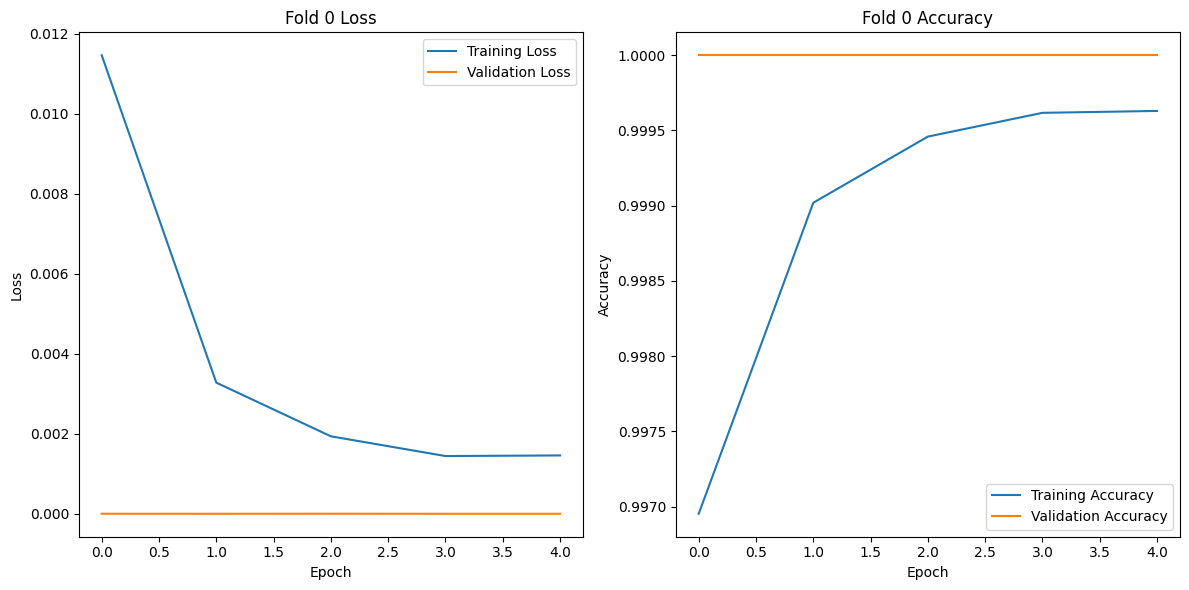

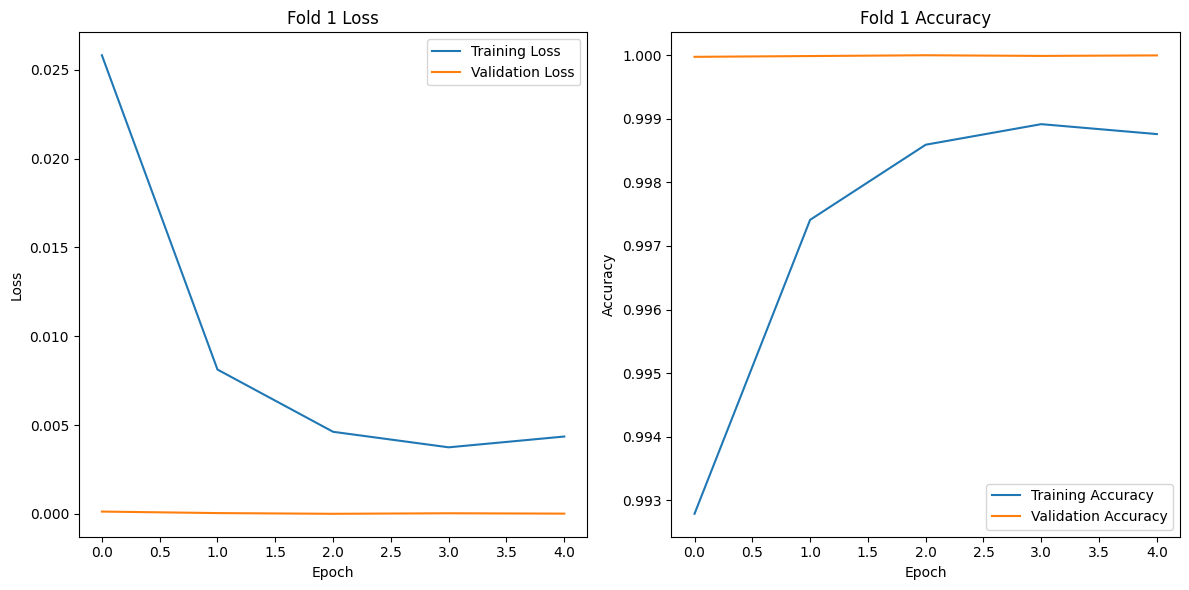

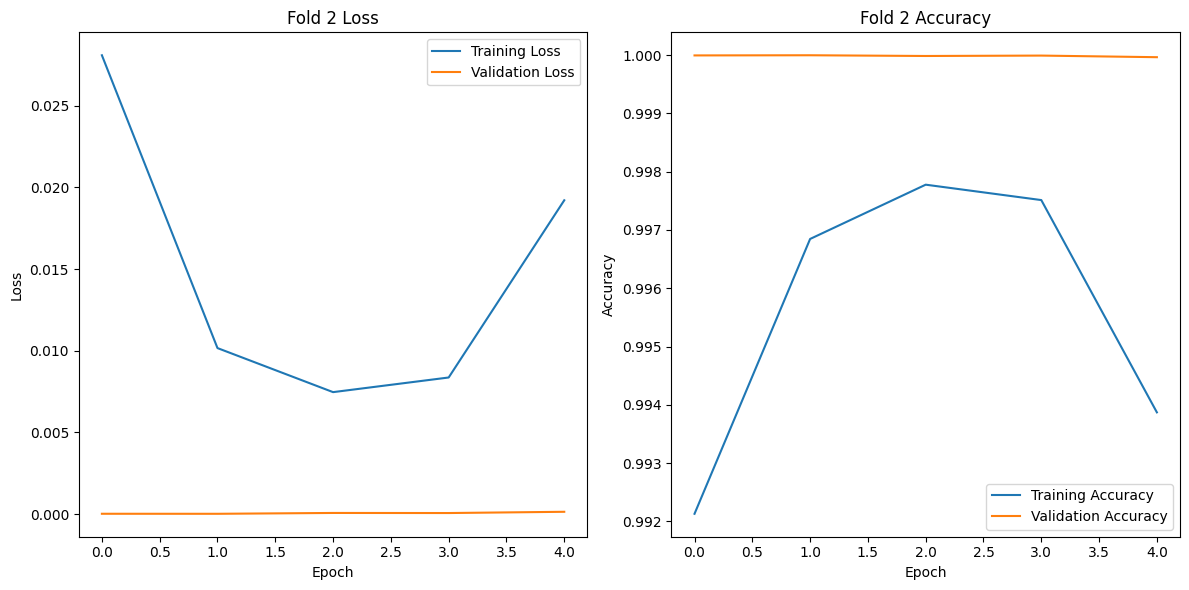

Evaluating Fold 0 LSTM model...
39061/39061 [==============================] - 245s 6ms/step
Fold 0 Metrics:
Precision: 0.5703, Recall: 0.1304, F1-Score: 0.2123, Accuracy: 0.9552
Classification Report for Fold 0:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98   1192051
         1.0       0.57      0.13      0.21     57900

    accuracy                           0.96   1249951
   macro avg       0.76      0.56      0.59   1249951
weighted avg       0.94      0.96      0.94   1249951

Evaluating Fold 1 LSTM model...
39061/39061 [==============================] - 262s 7ms/step
Fold 1 Metrics:
Precision: 0.2892, Recall: 0.1526, F1-Score: 0.1997, Accuracy: 0.9469
Classification Report for Fold 1:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97   1195651
         1.0       0.29      0.15      0.20     54300

    accuracy                           0.95   1249951
   macro avg       0.63      

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Load data
path = "drive/MyDrive/"
df = pd.read_csv(f'{path}data.csv')
df = df.drop('timestamp', axis=1)

# Split data into features and labels
X_df = df.drop(['y', 'category'], axis=1)
y_df = df['y']

# Initialize TimeSeriesSplit
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Preprocessing function
def preprocess_data(X_train, X_test, correlation_threshold=0.9):
    # Drop highly correlated features
    corr_matrix = X_train.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    X_train_reduced = X_train.drop(columns=to_drop)
    X_test_reduced = X_test.drop(columns=to_drop)

    # Scale continuous features
    scaler = StandardScaler()
    continuous_features = X_train_reduced.select_dtypes(include=['float64', 'int64']).columns
    X_train_reduced[continuous_features] = scaler.fit_transform(X_train_reduced[continuous_features])
    X_test_reduced[continuous_features] = scaler.transform(X_test_reduced[continuous_features])

    return X_train_reduced, X_test_reduced

# Augmentation function
def augment_data(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled

# Function to create sliding windows
def create_windows(X, y, window_size=50):
    X_windows, y_windows = [], []
    for i in range(len(X) - window_size + 1):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i + window_size - 1])  # Use the last label as target
    return np.array(X_windows), np.array(y_windows)

# Preprocess, augment, and window data for each fold
X_train_windows, y_train_windows = {}, {}
X_test_windows, y_test_windows = {}, {}

for fold, (train_index, test_index) in enumerate(tscv.split(X_df)):
    # Split data into train and test
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Preprocess the data
    X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

    # Augment the training data
    X_train_augmented, y_train_augmented = augment_data(X_train_scaled, y_train)

    # Convert to numpy arrays and create windows
    X_train_windows[fold], y_train_windows[fold] = create_windows(X_train_augmented.to_numpy(), y_train_augmented.to_numpy(), window_size=50)
    X_test_windows[fold], y_test_windows[fold] = create_windows(X_test_scaled.to_numpy(), y_test.to_numpy(), window_size=50)

    print(f"Fold {fold} data shapes - X_train: {X_train_windows[fold].shape}, y_train: {y_train_windows[fold].shape}")
    print(f"Fold {fold} data shapes - X_test: {X_test_windows[fold].shape}, y_test: {y_test_windows[fold].shape}")

# Function to train an LSTM
def train_lstm(X_train, y_train, X_val, y_val, n_units=64, n_epochs=5, batch_size=32):
    model = Sequential([
        LSTM(n_units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Display model summary
    model.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)
    return model, history

# Train LSTM model on each fold's data
lstm_models = {}
lstm_histories = {}

for fold in range(n_splits):
    # Use 90% of the train data for training and 10% for validation
    n_train = int(0.9 * len(X_train_windows[fold]))
    X_train_fold, X_val_fold = X_train_windows[fold][:n_train], X_train_windows[fold][n_train:]
    y_train_fold, y_val_fold = y_train_windows[fold][:n_train], y_train_windows[fold][n_train:]

    print(f"\nTraining LSTM model for Fold {fold}...")
    lstm_models[fold], lstm_histories[fold] = train_lstm(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    print(f"Fold {fold} LSTM model trained.\n")

# Plot training and validation loss and accuracy for each fold
for fold in range(n_splits):
    history = lstm_histories[fold]
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluate the models and calculate metrics
for fold in range(n_splits):
    print(f"Evaluating Fold {fold} LSTM model...")
    y_pred = lstm_models[fold].predict(X_test_windows[fold])
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    # Calculate metrics
    precision = precision_score(y_test_windows[fold], y_pred_classes)
    recall = recall_score(y_test_windows[fold], y_pred_classes)
    f1 = f1_score(y_test_windows[fold], y_pred_classes)
    accuracy = accuracy_score(y_test_windows[fold], y_pred_classes)

    print(f"Fold {fold} Metrics:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Classification Report for Fold {fold}:")
    print(classification_report(y_test_windows[fold], y_pred_classes))


39061/39061 [==============================] - 267s 7ms/step


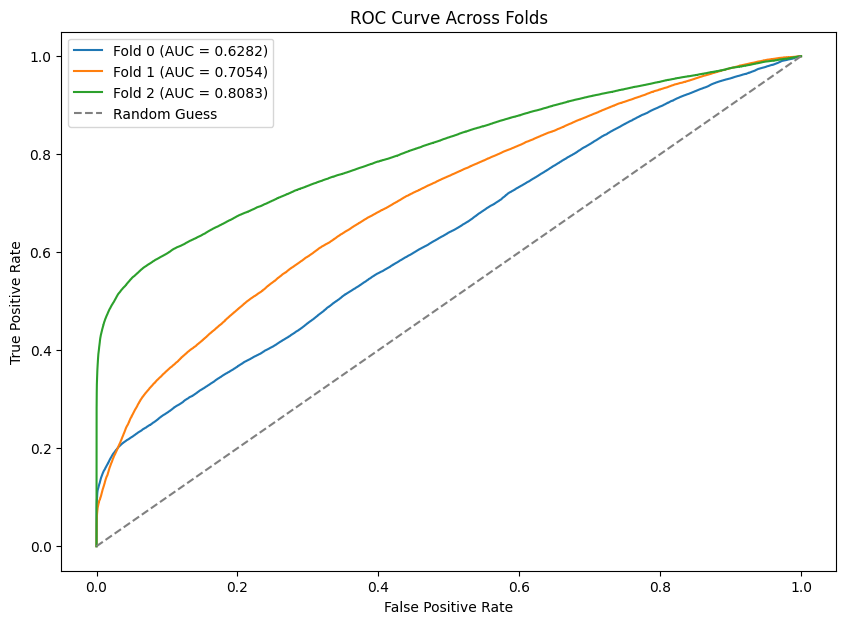

Average AUC Across Folds: 0.7140


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize lists to store AUC scores for each fold
all_auc = []

# Plot ROC curve for each fold
plt.figure(figsize=(10, 7))
for fold in range(n_splits):
    # Get true labels and predicted probabilities for the fold
    y_true = y_test_windows[fold]
    y_pred_probs = lstm_models[fold].predict(X_test_windows[fold]).flatten()  # Probabilities

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred_probs)
    all_auc.append(auc)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {auc:.4f})')

# Plot average ROC curve
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('ROC Curve Across Folds')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Calculate average AUC
average_auc = np.mean(all_auc)
print(f"Average AUC Across Folds: {average_auc:.4f}")


In [ ]:
# Initialize lists to store metrics for each fold
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Collect metrics from each fold
for fold in range(n_splits):
    y_pred = lstm_models[fold].predict(X_test_windows[fold])
    y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    # Append metrics to the respective lists
    precision_scores.append(precision_score(y_test_windows[fold], y_pred_classes))
    recall_scores.append(recall_score(y_test_windows[fold], y_pred_classes))
    f1_scores.append(f1_score(y_test_windows[fold], y_pred_classes))
    accuracy_scores.append(accuracy_score(y_test_windows[fold], y_pred_classes))

# Calculate average metrics
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_accuracy = np.mean(accuracy_scores)

# Display the average metrics
print("\nAverage Metrics Across All Folds:")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-Score: {avg_f1:.4f}")
print(f"Accuracy: {avg_accuracy:.4f}")


39061/39061 [==============================] - 259s 7ms/step

Average Metrics Across All Folds:
Precision: 0.4857
Recall: 0.2526
F1-Score: 0.3138
Accuracy: 0.9541


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Sample data (Replace with your data)
# X_train should be shaped as (num_samples, timesteps, num_features)
X_train = np.random.rand(100, 10, 5)  # Example shape (100 samples, 10 time steps, 5 features)

# Normalize data (to avoid NaN from large values)
X_train_mean = np.mean(X_train, axis=(0, 1), keepdims=True)
X_train_std = np.std(X_train, axis=(0, 1), keepdims=True)
X_train_normalized = (X_train - X_train_mean) / (X_train_std + 1e-7)  # Avoid division by 0

# Define LSTM Autoencoder
input_seq = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Shape: (timesteps, features)

# Encoder
x = LSTM(64, activation='tanh', return_sequences=False)(input_seq)
x = LayerNormalization()(x)  # Layer normalization to avoid exploding/vanishing gradients

# Latent Space (bottleneck)
latent = Dense(32, activation='relu')(x)

# Decoder
x = RepeatVector(X_train.shape[1])(latent)  # Repeat latent vector to match original sequence length
x = LSTM(64, activation='tanh', return_sequences=True)(x)
x = LayerNormalization()(x)

# Output layer
output_seq = Dense(X_train.shape[2])(x)

# Build model
autoencoder = Model(input_seq, output_seq)

# Compile the model with Adam optimizer and gradient clipping
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # Gradients clipped at value 1.0
autoencoder.compile(optimizer=optimizer, loss='mse')

# Learning Rate Scheduler (optional but helpful for adjusting the learning rate during training)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = autoencoder.fit(X_train_normalized, X_train_normalized, epochs=100, batch_size=32,
                          validation_split=0.1, callbacks=[lr_scheduler])

# After training, reconstruct the sequence using the autoencoder
reconstructed = autoencoder.predict(X_train_normalized)

# Post-processing (optional): Undo normalization if needed
reconstructed_original = reconstructed * X_train_std + X_train_mean  # Reverse normalization


Epoch 1/100
3/3 [==============================] - 4s 420ms/step - loss: 2.0167 - val_loss: 1.5676 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 37ms/step - loss: 1.2969 - val_loss: 1.2451 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 37ms/step - loss: 1.1119 - val_loss: 1.0658 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 33ms/step - loss: 1.0519 - val_loss: 0.9869 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 34ms/step - loss: 1.0191 - val_loss: 0.9546 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 33ms/step - loss: 0.9909 - val_loss: 0.9392 - lr: 0.0010
Epoch 7/100
3/3 [==============================] - 0s 33ms/step - loss: 0.9639 - val_loss: 0.9268 - lr: 0.0010
Epoch 8/100
3/3 [==============================] - 0s 33ms/step - loss: 0.9426 - val_loss: 0.9122 - lr: 0.0010
Epoch 9/100
3/3 [==============================] - 0s 33ms/step - loss: 0.9329 - val_loss: 0.8972 - lr: 0.0010


In [ ]:
from keras import regularizers
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import numpy as np
import tensorflow as tf

# Define the autoencoder architecture
def create_autoencoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    # Encoder
    encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)

    # Latent space representation
    latent = Dense(latent_dim, activation='relu')(encoded)

    # Decoder
    decoded = RepeatVector(input_shape[0])(latent)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)

    # Compile model
    autoencoder = Model(inputs, decoded)
    return autoencoder

# Prepare your data (e.g., X_train)
# Ensure no NaNs in data
X_train = np.random.randn(100, 10, 1)  # Example data
X_train = np.nan_to_num(X_train)  # Replace NaNs with zeros

# Set parameters
input_shape = X_train.shape[1:]  # (timesteps, features)
latent_dim = 10  # Latent space dimension

# Create and compile the model
autoencoder = create_autoencoder(input_shape, latent_dim)
optimizer = Adam(learning_rate=0.0005)  # Lower learning rate to prevent NaNs
autoencoder.compile(optimizer=optimizer, loss='mse')

# Add gradient clipping to prevent exploding gradients
optimizer = Adam(learning_rate=0.0005, clipvalue=1.0)  # Clip gradients if they exceed 1.0
autoencoder.compile(optimizer=optimizer, loss='mse')

# Display model summary
autoencoder.summary()

# Train the model
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm_13 (LSTM)              (None, 10, 128)           66560     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
 repeat_vector_4 (RepeatVec  (None, 10, 10)            0         
 tor)                                                            
                                                                 
 lstm_15 (LSTM)              (None, 10, 64)            19200     
                                                           

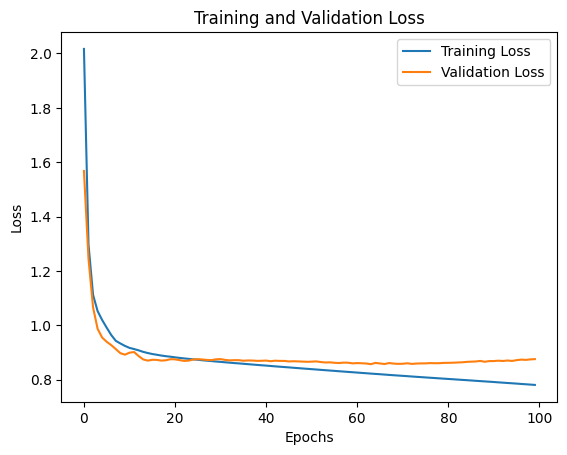

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' contains your training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Accuracy: 1.0000


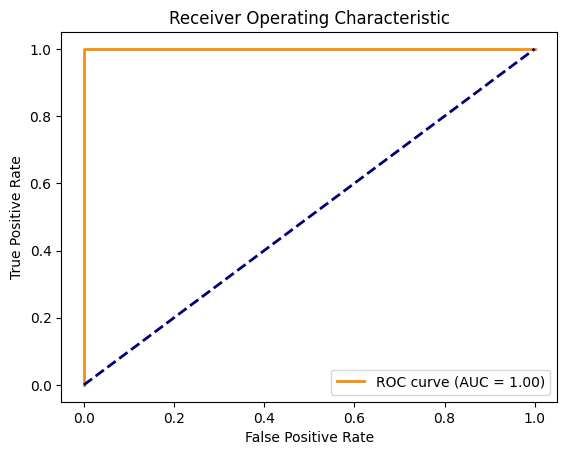

Average Evaluation Score: 1.0000


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Example: Define reconstruction errors and labels for anomaly detection
reconstruction_errors = np.array([0.1, 0.5, 1.5, 0.3, 0.2])  # Example reconstruction errors
threshold = 0.5  # Example threshold for anomaly detection
y_true = np.array([0, 0, 1, 0, 0])  # True labels: 0 = normal, 1 = anomalous

# Predicted labels based on reconstruction error threshold
y_pred = (reconstruction_errors > threshold).astype(int)  # 1 if anomaly, 0 if normal

# Calculate Precision, Recall, F1 Score, and Accuracy
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Print the evaluation metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(y_true, reconstruction_errors)  # Using reconstruction errors for ROC
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Average Evaluation Score
average_score = (precision + recall + f1 + accuracy) / 4
print(f'Average Evaluation Score: {average_score:.4f}')



In [ ]:
average_score = (precision + recall + f1) / 3
print(f'Average Evaluation Score: {average_score:.4f}')



Average Evaluation Score: 1.0000


Done

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Function to train an Autoencoder
def train_autoencoder(X_train, X_val, n_units=64, n_epochs=5, batch_size=32):
    """
    Train an LSTM-based Autoencoder for anomaly detection.

    Parameters:
    X_train (array): Training data.
    X_val (array): Validation data.
    n_units (int): Number of units in LSTM layers.
    n_epochs (int): Number of training epochs.
    batch_size (int): Batch size.

    Returns:
    Model: Trained Autoencoder model.
    History: Training history.
    """
    # Build Autoencoder model
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    encoder = LSTM(n_units, activation='relu', return_sequences=False)(input_layer)
    decoder = RepeatVector(X_train.shape[1])(encoder)
    decoder = LSTM(n_units, activation='relu', return_sequences=True)(decoder)
    output_layer = TimeDistributed(Dense(X_train.shape[2]))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Display model summary
    autoencoder.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train Autoencoder
    history = autoencoder.fit(
        X_train, X_train,
        epochs=n_epochs,  # Set to 5 epochs
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return autoencoder, history

# Train Autoencoder on each fold
autoencoder_models = {}
autoencoder_histories = {}

for fold in range(n_splits):
    # Use 90% of the train data for training and 10% for validation
    n_train = int(0.9 * len(X_train_windows[fold]))
    X_train_fold, X_val_fold = X_train_windows[fold][:n_train], X_train_windows[fold][n_train:]

    print(f"\nTraining Autoencoder for Fold {fold} with 5 epochs...")
    autoencoder_models[fold], autoencoder_histories[fold] = train_autoencoder(
        X_train_fold,
        X_val_fold,
        n_units=64,
        n_epochs=5,  # Set to 5 epochs
        batch_size=32
    )
    print(f"Fold {fold} Autoencoder trained.\n")

# Plot training and validation loss for Autoencoder
for fold in range(n_splits):
    history = autoencoder_histories[fold]
    plt.figure(figsize=(12, 6))

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Autoencoder Training and Validation Loss (5 epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Evaluate Autoencoder on test data
def evaluate_autoencoder(autoencoder, X_test, y_test, threshold=0.01):
    """
    Evaluate an Autoencoder model for anomaly detection.

    Parameters:
    autoencoder (Model): Trained Autoencoder.
    X_test (array): Test data.
    y_test (array): True labels.
    threshold (float): Reconstruction error threshold for classifying anomalies.

    Returns:
    Metrics: Precision, Recall, F1-Score, Accuracy, and classification report.
    """
    # Calculate reconstruction errors
    reconstructed = autoencoder.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - reconstructed), axis=(1, 2))

    # Classify anomalies based on the threshold
    y_pred = (reconstruction_error > threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return precision, recall, f1, accuracy, reconstruction_error, y_pred

# Evaluate each fold
threshold = 0.01  # Adjust threshold based on your data
for fold in range(n_splits):
    print(f"Evaluating Autoencoder for Fold {fold}...")
    precision, recall, f1, accuracy, reconstruction_error, y_pred = evaluate_autoencoder(
        autoencoder_models[fold],
        X_test_windows[fold],
        y_test_windows[fold],
        threshold
    )

    print(f"Fold {fold} Metrics:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Classification Report for Fold {fold}:")
    print(classification_report(y_test_windows[fold], y_pred))

    # Plot reconstruction error distribution
    plt.figure(figsize=(12, 6))
    plt.hist(reconstruction_error, bins=50, alpha=0.75)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
    plt.title(f'Fold {fold} Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()



Training Autoencoder for Fold 0 with 5 epochs...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 16)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                20736     
                                                                 
 repeat_vector (RepeatVecto  (None, 50, 64)            0         
 r)                                                              
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            33024     
                                                                 
 time_distributed (TimeDist  (None, 50, 16)            1040      
 ributed)                                                        
                                                                 
Total param

KeyboardInterrupt: 

In [ ]:
# Initialize lists to store metrics for each fold
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Collect metrics from each fold
for fold in range(n_splits):
    print(f"Evaluating Autoencoder for Fold {fold}...")
    precision, recall, f1, accuracy, reconstruction_error, y_pred = evaluate_autoencoder(
        autoencoder_models[fold],
        X_test_windows[fold],
        y_test_windows[fold],
        threshold
    )

    # Append metrics to the respective lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculate average metrics
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_accuracy = np.mean(accuracy_scores)

# Display average metrics
print("\nAverage Metrics Across All Folds:")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall: {avg_recall:.4f}")
print(f"F1-Score: {avg_f1:.4f}")
print(f"Accuracy: {avg_accuracy:.4f}")


In [ ]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curve for each fold
plt.figure(figsize=(12, 8))

for fold in range(n_splits):
    # Get reconstruction errors and true labels
    _, _, _, _, reconstruction_error, y_pred = evaluate_autoencoder(
        autoencoder_models[fold],
        X_test_windows[fold],
        y_test_windows[fold],
        threshold
    )

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_windows[fold], reconstruction_error)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC = {roc_auc:.4f})')

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Finalize plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
